In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models, utils

# Keras의 함수형 API

## 다중 입력 모델 (2->1)

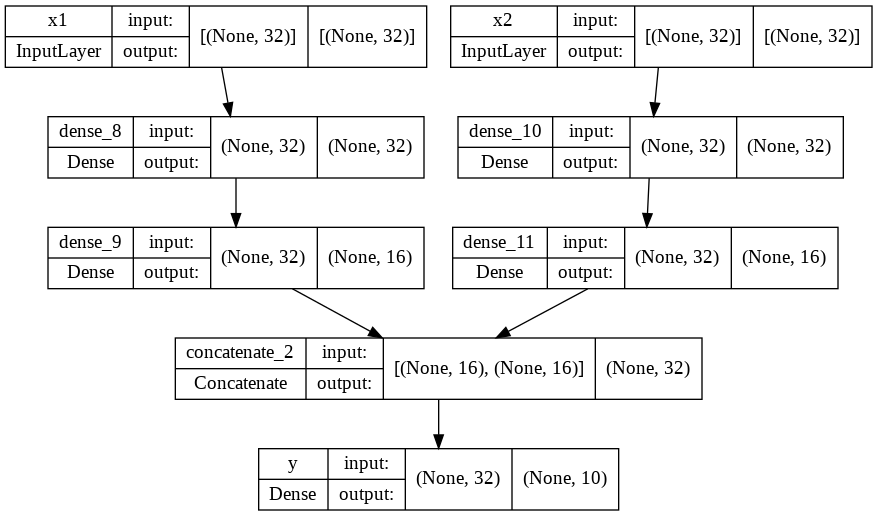

In [5]:
def build_multi_input_model():
    x1 = layers.Input(shape=32, name='x1')
    y1 = layers.Dense(32, activation='relu')(x1)
    y1 = layers.Dense(16, activation='relu')(y1)

    x2 = layers.Input(shape=32, name='x2')
    y2 = layers.Dense(32, activation='relu')(x2)
    y2 = layers.Dense(16, activation='relu')(y2)

    # 두개의 브랜치를 하나로 합치기
    y = layers.concatenate([y1, y2])
    y = layers.Dense(10, activation='softmax', name='y')(y)  # 10개 클래스
    return models.Model(inputs=[x1, x2], outputs=y)

model = build_multi_input_model()
utils.plot_model(model, show_shapes=True)

## 다중 출력 모델 (1->2)

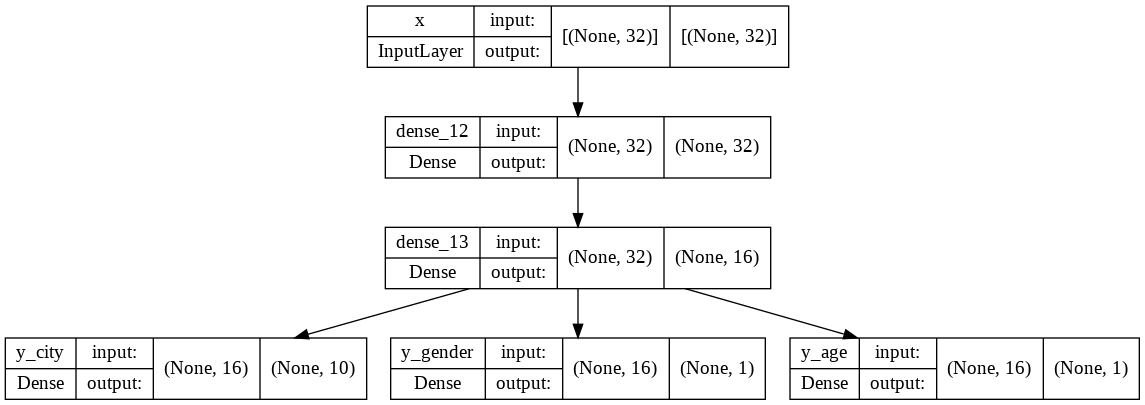

In [6]:
def build_multi_output_model():
    x = layers.Input(shape=32, name='x')
    y = layers.Dense(32, activation='relu')(x)
    y = layers.Dense(16, activation='relu')(y)

    y_city = layers.Dense(10, activation='softmax',
                          name='y_city')(y)  # 10개 지역 (다중분류)
    y_gender = layers.Dense(1, activation='sigmoid',
                            name='y_gender')(y)  # 이진분류
    y_age = layers.Dense(1, name='y_age')(y)  # 회귀
    return models.Model(inputs=x, outputs=[y_city, y_gender, y_age])

model = build_multi_output_model()
utils.plot_model(model, show_shapes=True)

## 복잡한 네트워크(인셉션 모듈, 잔차연결)

### 인셉션 모듈

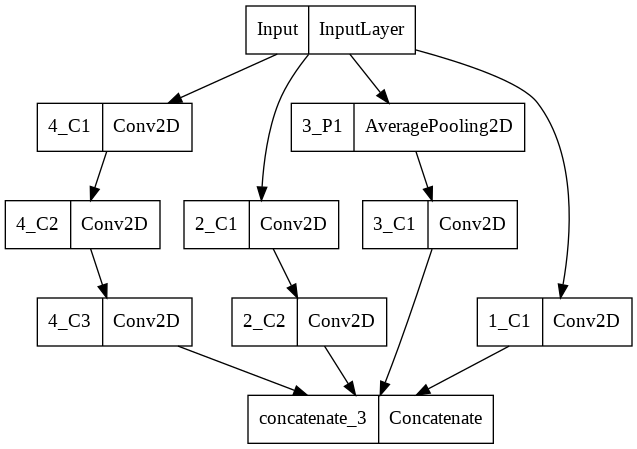

In [8]:
def InceptionModule(x):

    a = layers.Conv2D(128, 1, strides=2, padding='same', activation='relu', name="1_C1")(x)

    b = layers.Conv2D(128, 1, strides=1, padding="same", activation="relu", name="2_C1")(x)
    b = layers.Conv2D(128, 3, strides=2, padding="same", activation="relu", name="2_C2")(b)

    c = layers.AvgPool2D(pool_size=3, strides=2, padding="same", name="3_P1")(x)
    c = layers.Conv2D(128, 3, strides=1, padding="same", activation="relu",name="3_C1")(c)

    d = layers.Conv2D(128, 1, strides=1, padding="same", activation="relu", name="4_C1")(x)
    d = layers.Conv2D(128, 3, strides=1, padding="same", activation="relu", name="4_C2")(d)
    d = layers.Conv2D(128, 3, strides=2, padding="same", activation="relu", name="4_C3")(d)

    y = layers.concatenate([a, b, c, d], axis=-1)

    return y

def build_model():
    x = layers.Input(shape=(224,224,3), name="Input")
    y = InceptionModule(x)
    return models.Model(x,y)
model = build_model()
utils.plot_model(model)

### 잔차연결

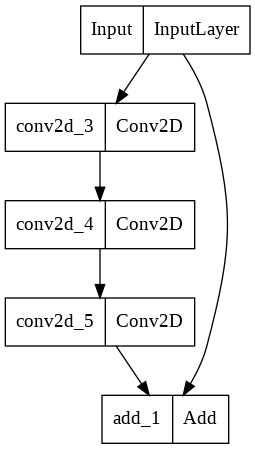

In [11]:
def ResidualBlock(x):
    y = layers.Conv2D(128, 3, activation="relu", padding="same")(x)
    y = layers.Conv2D(128, 3, activation="relu", padding="same")(y)
    y = layers.Conv2D(128, 3, activation="relu", padding="same")(y)
    y = layers.add([y,x])
    return y

def build_model():
    x = layers.Input(shape=(224,224,128), name="Input")
    y = ResidualBlock(x)
    return models.Model(x,y)
model = build_model()
utils.plot_model(model)

## 층 가중치 공유

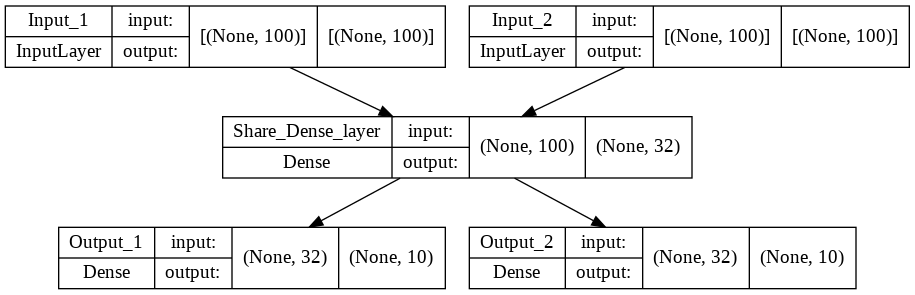

In [12]:
def shared_model():
    D1 = layers.Dense(32, name="Share_Dense_layer")  # 층
    
    x1 = layers.Input(shape=(100), name="Input_1")
    y1 = D1(x1) # D1 층 사용
    y1 = layers.Dense(10, name="Output_1")(y1)
    
    x2 = layers.Input(shape=(100), name="Input_2")
    y2 = D1(x2) # D1 층 재사용
    y2 = layers.Dense(10, name="Output_2")(y2)
    
    return models.Model([x1, x2], [y1, y2])

model =shared_model()
utils.plot_model(model, show_shapes=True)

## 이미 구현된 모델 가져오기

* tf.keras.applications 을 통해 이미 구현되어있는 모델을 불러올 수 있음

In [13]:
base_model = tf.keras.applications.VGG16(weights=None, # 전이학습을 하지 않음
                                        include_top=True, # False 이면 input의 shape가 전이되지 않음 
                                        )
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     